<a href="https://colab.research.google.com/github/miiklee/thesis_webscraping/blob/main/nyt_webscraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Webscraping and Formatting Code

This is a file containing all the code I wrote and used in the research for my undergrad history thesis at Barnard College of Columbia University on trends in reporting about genocide in the New York Times.

shout out to my advisors Lisa Tiersten and Nara Milanich who have been consistently excited by my code as they have no CS background :)


***
Contents:
1. NYT Article Search API Webscraping based on term query
2. Concatenating Data from multiple CSVs
3. Counting Keyword Prevalence
4. Matplotlib Graphing Data



In [ ]:
import requests as req
import time
import pandas as pd
import numpy as np
import dateutil


def send_request(i):
    '''Sends a request to the NYT Article Search API'''
    TERM = 'genocide'
    url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key=' + 'A1sFysFjkau1KVcvIPFzoGCQIPASKatf' + '&q=' + TERM + '&page=' + str(i)
    response = req.get(url).json()
    time.sleep(6)
    return response



def parse_response(response):
    '''Parses and returns response as pandas data frame.'''
    data = {'headline': [],  
        'date': [], 
        'doc_type': [],
        'material_type': [],
        'section': [],
        'page': [],
        'keywords': [],
        'url': [],
        'word_count':[]}

    if 'response' in response:
      articles = response['response']['docs'] 
      for article in articles: # go throughand parse each article
          if is_valid(article):
              data['date'].append(dateutil.parser.parse(article['pub_date']).date())
              data['headline'].append(article['headline']['main']) 
              if 'print_section' in article:
                  data['section'].append(article['print_section'])
              else:
                  data['section'].append(None)
              data['page'].append(article['print_page'])
              data['doc_type'].append(article['document_type'])
              if 'type_of_material' in article: 
                  data['material_type'].append(article['type_of_material'])
              else:
                  data['material_type'].append(None)
              keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
              data['keywords'].append(keywords)
              if 'web_url' in article:
                data['url'].append(article['web_url'])
              data['word_count'].append(article['word_count'])
      
      return pd.DataFrame(data) 



def is_valid(article):
  if 'print_page' in article:
    return True
  else:
    return False


'''Send and parse request/response to/from NYT Archive API for given dates.'''
for i in range(200,230):
    response = send_request(i)
    if(i == 0):
        df = parse_response(response)
    else:
      df = df.append(parse_response(response))

df.drop_duplicates(subset=['headline', 'date'])
df.to_csv('gen.csv')

Number of articles collected: 1628


In [35]:
import csv
import pandas as pd #so you don't have to re-run the above cell

def count_keywords(data):
  tracker = {}
  word_count = 0
  fieldnames = ['word count']

  ''' make into a dictionary tracking prevalence of each keyword  '''
  for line in data:
    for word in line:
      if word in tracker:
        tracker[word] += 1
      else:
        tracker[word] = 1
        word_count += 1
        fieldnames.append(word)

    #total number of keywords
  tracker['word count'] = word_count
  return [tracker, fieldnames]


file = open("keywords_uncounted.csv", "r")
keywords = list(csv.reader(file, delimiter=","))
file.close()

data = count_keywords(keywords)
with open('keywords.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data[1])
    writer.writeheader()
    writer.writerow(data[0])


In [ ]:
'''  read in info from csvs, clean up, make into dataframe  '''
data1 = pd.read_csv('genocide.csv')
data2 = (pd.read_csv('mass_killing.csv'))
data3 = (pd.read_csv('massacre.csv'))
data4 = (pd.read_csv('ethnic_cleansing.csv'))
data = pd.concat([data1, data2, data3, data4])
data.drop_duplicates(subset=['headline', 'date'])

data.to_csv('all.csv')

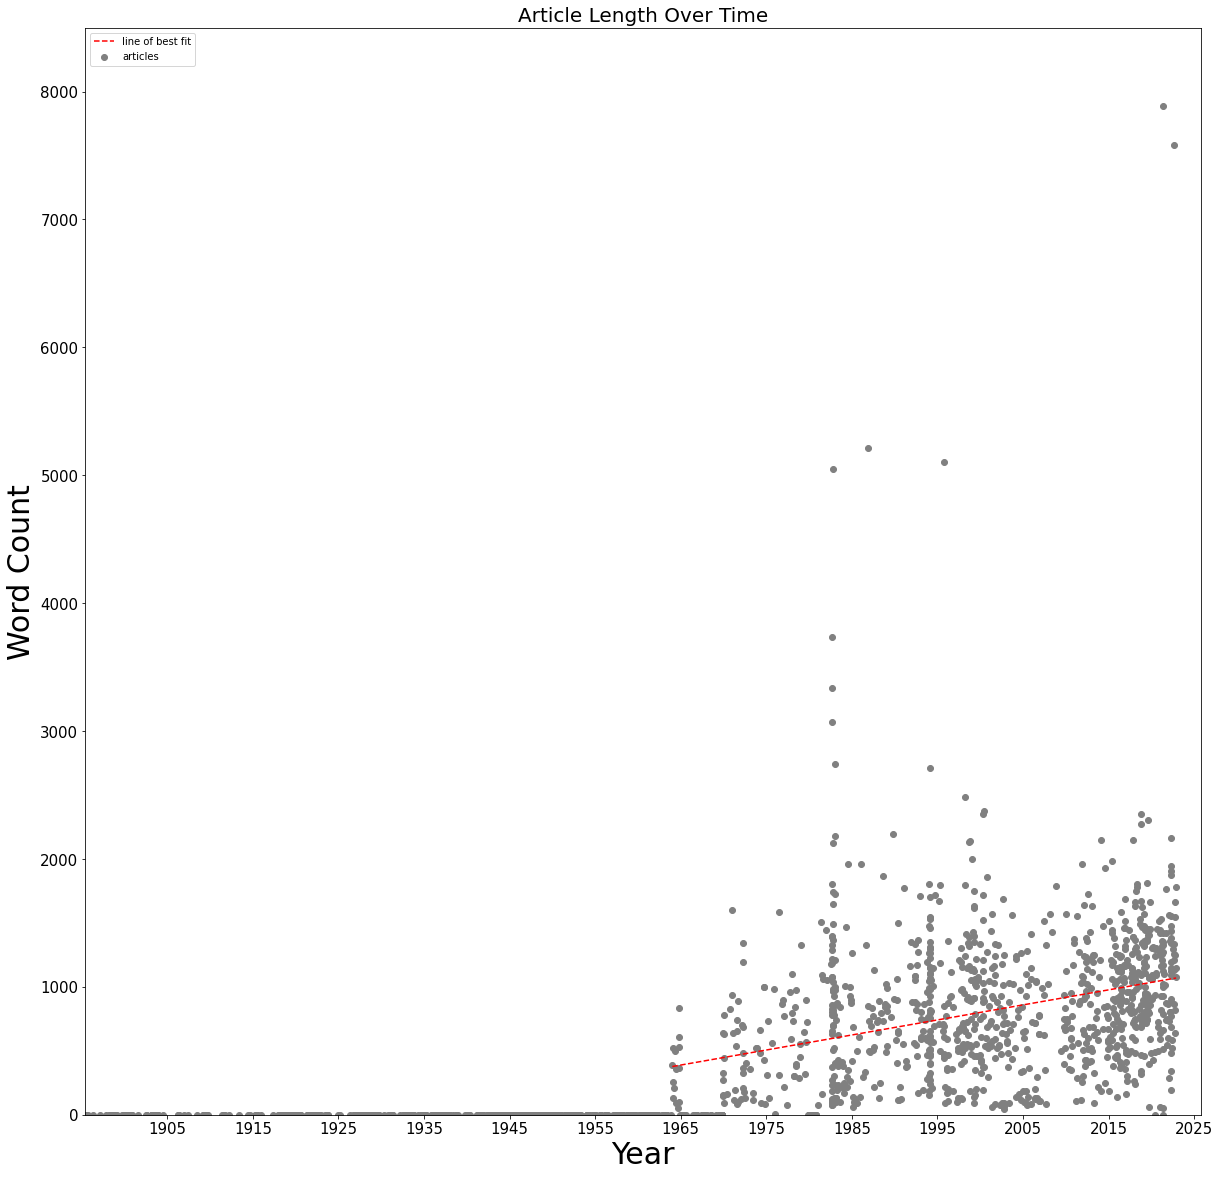

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

from datetime import date
from datetime import datetime


'''  csv into dataframe  '''
dt = pd.read_csv('massacre.csv')
dt.sort_values(by='date', inplace = True) # sort df in chronological order


def make_graph(frame):

  '''  style  '''
  
  plt.rc('axes', labelsize=30)     # font size of the axes title
  plt.rc('figure', titlesize=50)  # font size of the graph title
  plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

  '''  format x and y values,   '''
  dates = frame['date'].values.tolist()
  x = [datetime.strptime(d,'%Y-%m-%d').date() for d in dates] # str to datetime
  y = frame['word_count'].values.tolist() # column to list

  '''  x axis tick marks  '''
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # only year
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3650)) # every 10

  '''  actually plot '''
  plt.scatter(x, y, color='gray', label='articles') #label for key
  plt.title('Article Length Over Time')
  plt.xlabel('Year')
  plt.ylabel('Word Count')


  '''  dates into ints for LOBF calculations '''
  x_num = mdates.date2num(x)
  # for zooming in to a specific range
  min = mdates.date2num(datetime.strptime('2/16/1964','%m/%d/%Y').date())

  '''  calculate line of best fit  '''
  trend = np.polyfit(x_num, y, 1)
  fit = np.poly1d(trend)
  x_fit = np.linspace(min, x_num.max()) # start at date where data starts
  plt.plot(mdates.num2date(x_fit), fit(x_fit), "r--", label='line of best fit')


  '''  have a legend '''
  plt.legend(loc="upper left")

  '''  pick axes and plot size  '''
  plt.ylim(bottom=0, top=8500)
  plt.xlim(left=x_num.min()) #min-(3650/2)
  fig = plt.gcf()
  fig.set_size_inches(20, 20)
  fig.savefig('test4png.png', dpi=100) # save graph as a png

  plt.show() # show me the plot now


make_graph(dt)

In [ ]:
def in_range(date, start, end):
  if date >= start and date <= end:
      return True
  else:
    return False

dates1=[]
for date in dates:
  dates1.append(datetime(date.year, date.month, date.day))


armenia = 0
cambodia = 0
rwanda = 0
rohingya = 0
for date in dates1:
  start, end = datetime(1915, 1, 1), datetime(1917, 1, 1)
  if in_range(date, start, end):
    armenia += 1
  
  start, end = datetime(1975, 4, 17), datetime(1979, 1, 7)
  if in_range(date, start, end):
    cambodia += 1

  start, end = datetime(1994, 4, 7), datetime(1994, 7, 15)
  if in_range(date, start, end):
    rwanda += 1

  start, end = datetime(2016, 10, 9), datetime(2023, 1, 10)
  if in_range(date, start, end):
    rohingya += 1


totals = [armenia, cambodia, rwanda, rohingya]
print(totals)



[0, 7, 5, 142]
